# Import necessary python packages

In [1]:
import os
import shutil
import subprocess

from rdkit.Chem import AllChem
import py3Dmol

from importlib_resources import files

# Load packages from silc

In [2]:
import silc.util as util
from silc.build_molecule import binding_molecule
from silc.force_field import gaff2

In [3]:
def replaceDummy(smiles, new="*"):
    return smiles.replace("*",new)

# Some example cores

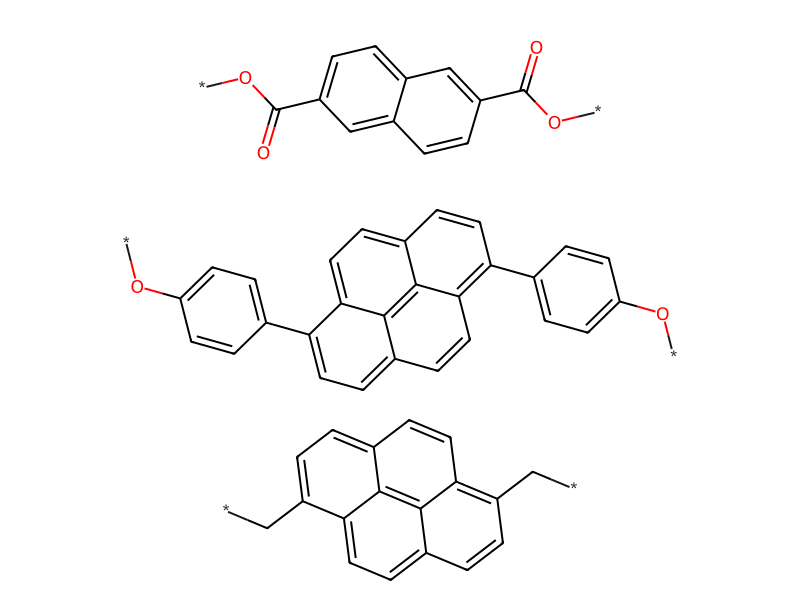

In [4]:
core1_smiles = "*OC(=O)c1ccc2cc(ccc2c1)C(=O)O*"
core2_smiles = "*Oc6ccc(c2ccc3ccc5c(c1ccc(O*)cc1)ccc4ccc2c3c45)cc6"
core3_smiles = "*C(c2ccc3ccc5c(C*)ccc4ccc2c3c45)"

core1 = AllChem.MolFromSmiles(replaceDummy(core1_smiles))
core2 = AllChem.MolFromSmiles(replaceDummy(core2_smiles))
core3 = AllChem.MolFromSmiles(replaceDummy(core3_smiles))

img = AllChem.Draw.MolsToGridImage([core1, core2, core3], molsPerRow=1, subImgSize=(800, 200))
img

# Some example tails

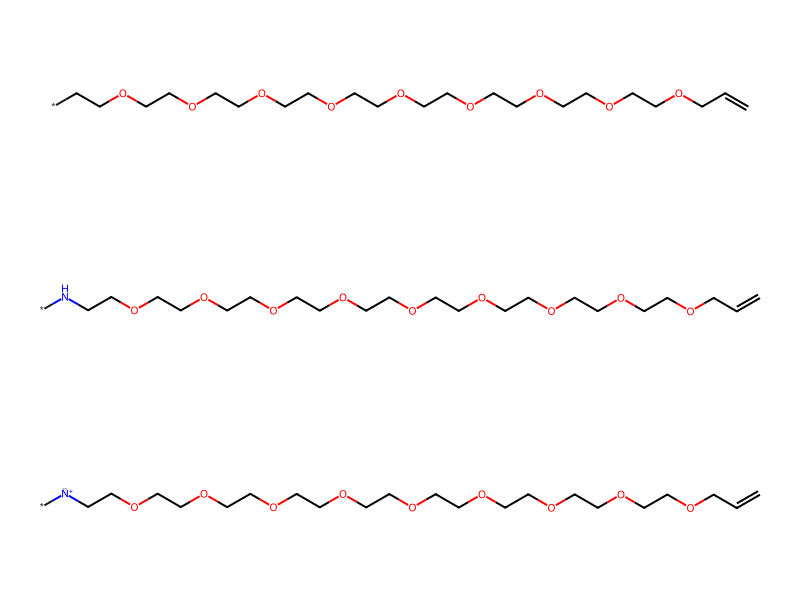

In [5]:
tail1_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "*"
tail2_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "N" + "*"
tail3_smiles = lambda nEO: "C=CC" + "OCC"*nEO + "[N+]" + "*"

nEO = 9
tail1 = AllChem.MolFromSmiles(replaceDummy(tail1_smiles(nEO)))
tail2 = AllChem.MolFromSmiles(replaceDummy(tail2_smiles(nEO)))
tail3 = AllChem.MolFromSmiles(replaceDummy(tail3_smiles(nEO)))

img = AllChem.Draw.MolsToGridImage([tail1, tail2, tail3], molsPerRow=1, subImgSize=(800, 200))
img

# Some example bridges

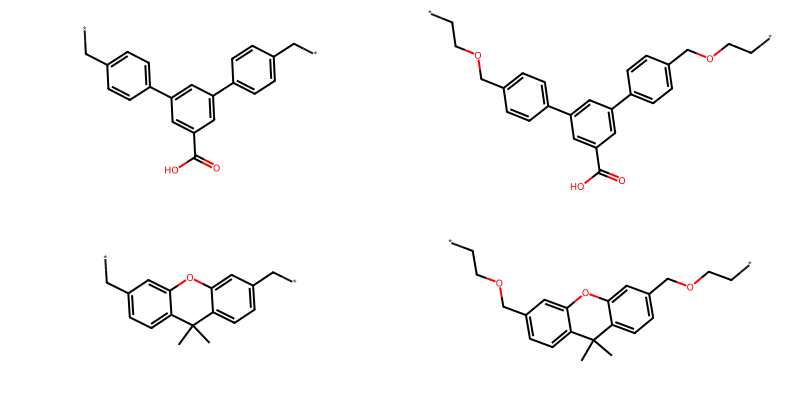

In [6]:
bridge1_smiles = lambda nEO: "O=C(O)c1cc(c2ccc(C" + "OCC" * nEO + "*)cc2)cc(c2ccc(C" + "OCC" * nEO + "*)cc2)c1"
bridge2_smiles = lambda nEO: "CC1(C)c2ccc(C" + "OCC" * nEO + "*)cc2Oc2cc(C" + "OCC" * nEO + "*)ccc21"

nEO_B = 0
bridge1_0 = AllChem.MolFromSmiles(replaceDummy(bridge1_smiles(nEO_B)))
bridge2_0 = AllChem.MolFromSmiles(replaceDummy(bridge2_smiles(nEO_B)))
nEO_B = 1
bridge1_1 = AllChem.MolFromSmiles(replaceDummy(bridge1_smiles(nEO_B)))
bridge2_1 = AllChem.MolFromSmiles(replaceDummy(bridge2_smiles(nEO_B)))
img = AllChem.Draw.MolsToGridImage([bridge1_0, bridge1_1, bridge2_0, bridge2_1], molsPerRow=2, subImgSize=(400, 200))
img

# Create ditopic binding motifs by "reaction" in RDKit
Here we demonstrate the formation of a ditopic binding motif

We first define reaction rule

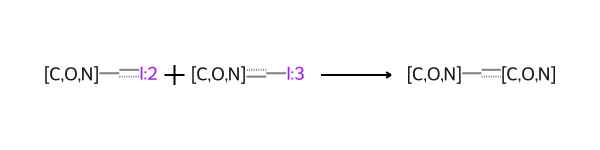

In [7]:
rxn = AllChem.rdChemReactions.ReactionFromSmarts("[C,O,N:1][I:2].[I:3][C,O,N:4]>>[C,O,N:1][C,O,N:4]")
rxn

Create a reactant, where we change the dummy atom to I for reactions

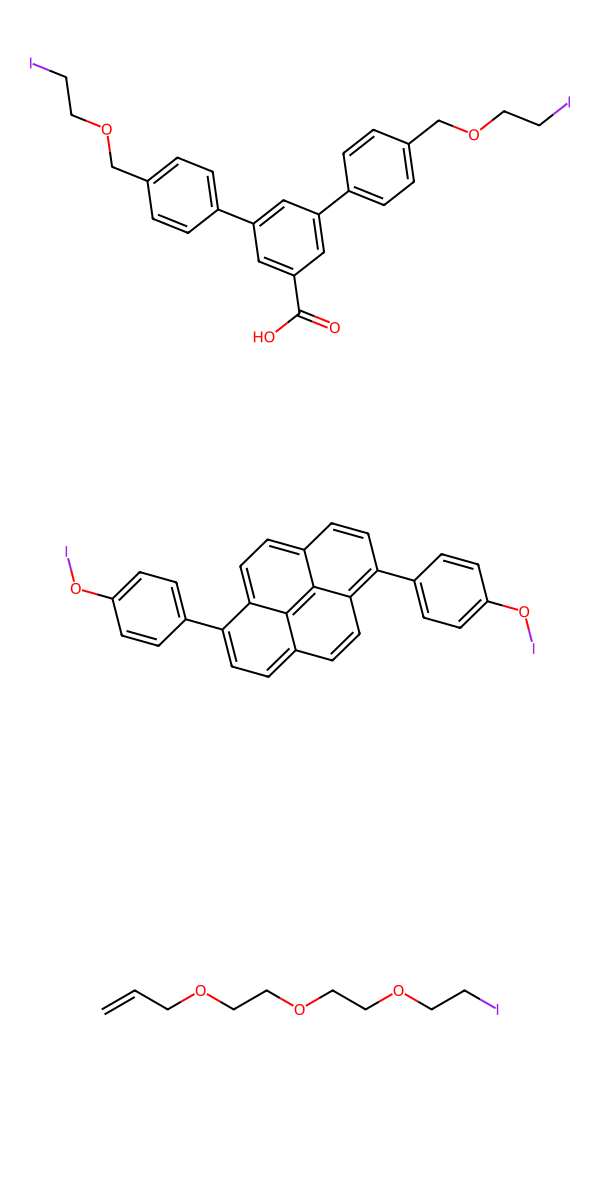

In [8]:
A = AllChem.MolFromSmiles(replaceDummy(bridge1_smiles(1), new="I"))
B = AllChem.MolFromSmiles(replaceDummy(core2_smiles, new="I"))
C = AllChem.MolFromSmiles(replaceDummy(tail1_smiles(3), new="I"))
img = AllChem.Draw.MolsToGridImage([A, B, C], molsPerRow=1, subImgSize=(600, 400))
img

Reaction takes three steps: \
(1) B(core) + C(tail) -> BC, since B has two I groups, there will be two possible but equivalent products. \
(2) BC + A -> BCA, since A has two I groups, there will be two possible but equivalent products. \
(3) BC + BCA -> BCACB, only one possible product

2


[00:20:55] mapped atoms in the reactants were not mapped in the products.
  unmapped numbers are: 2 3 


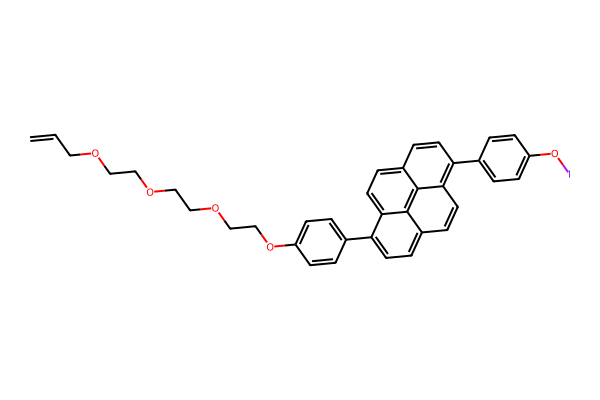

In [9]:
reacts = (B, C)
products = rxn.RunReactants(reacts)
print(len(products))    # output will be 2, since there will be two possible but equivalent products
BC = products[0][0]   # chose the first possible product (it does not make a different if we chose the second one by prod1 = products_1[1][0]
AllChem.SanitizeMol(BC)
img = AllChem.Draw.MolsToGridImage([BC], molsPerRow=1, subImgSize=(600, 400))
img

2


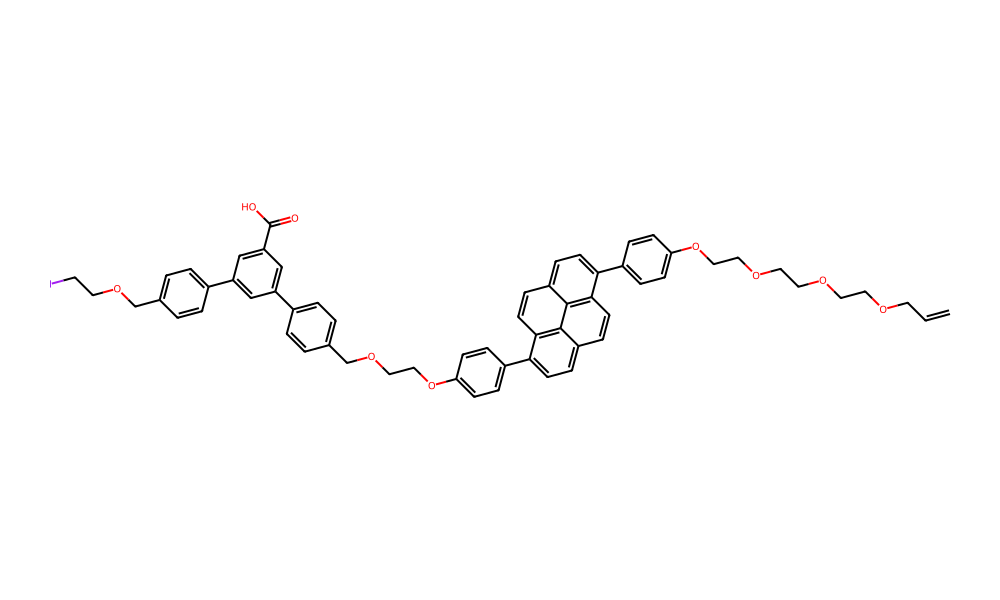

In [10]:
reacts = (BC, A)
products = rxn.RunReactants(reacts)
print(len(products))    # output will be 2, since there will be two possible but equivalent products
BCA = products[0][0]   # chose the first possible product (it does not make a different if we chose the second one by prod1 = products_1[1][0]
AllChem.SanitizeMol(BCA)
img = AllChem.Draw.MolsToGridImage([BCA], molsPerRow=1, subImgSize=(1000, 600))
img

1


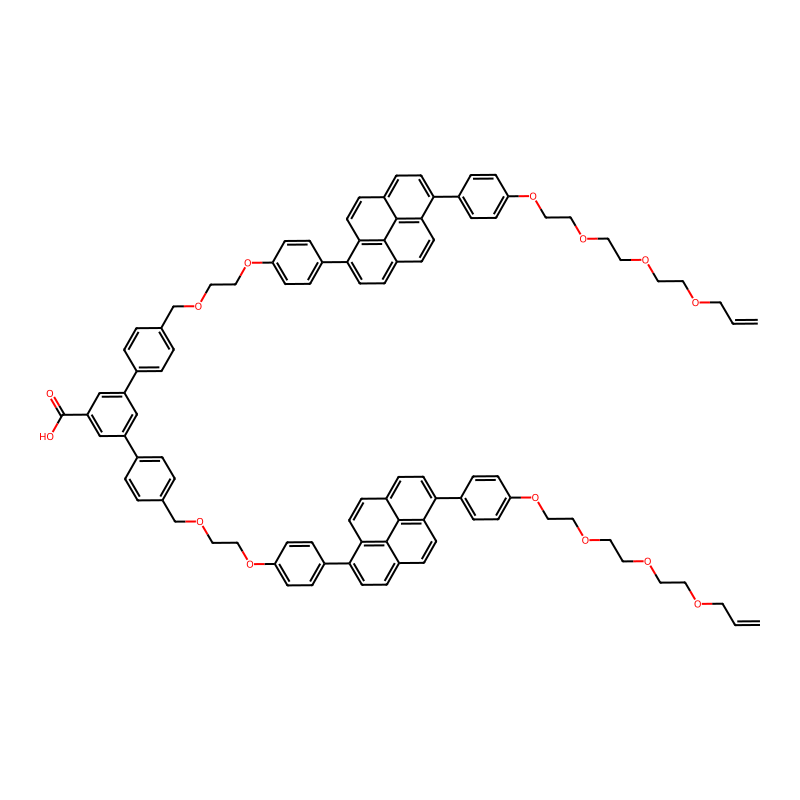

In [11]:
reacts = (BC, BCA)
products = rxn.RunReactants(reacts)
print(len(products))    # output will be 1, only one possible product
BCACB = products[0][0]
AllChem.SanitizeMol(BCACB)
img = AllChem.Draw.MolsToGridImage([BCACB], molsPerRow=1, subImgSize=(800, 800))
img

# Build residue files for molecular fragments

In [12]:
dm = binding_molecule()
dm.set_core_smiles(core2_smiles, "C")
dm.set_tail_smiles(tail1_smiles(3), "O")
dm.set_bridge_smiles(bridge1_smiles(1), "O")
dm.set_core_num_confs_for_charge(1)
dm.set_tail_num_confs_for_charge(5)
dm.set_bridge_num_confs_for_charge(5)
dm.set_work_path(files('silc.data.tutorial').joinpath("build_molecules"))
#dm.clear_work_path()    # this will remove the work_path, it is only for building new molecules from new segments

# Build a binding motif (i.e., tail-core-tail)

In [13]:
dm.create_binding_motif()

-I: Adding /home/heyi/env/py38/dat/leap/prep to search path.
-I: Adding /home/heyi/env/py38/dat/leap/lib to search path.
-I: Adding /home/heyi/env/py38/dat/leap/parm to search path.
-I: Adding /home/heyi/env/py38/dat/leap/cmd to search path.
-f: Source tleap_motif.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleap_motif.in
----- Source: /home/heyi/env/py38/dat/leap/cmd/leaprc.gaff2
----- Source of /home/heyi/env/py38/dat/leap/cmd/leaprc.gaff2 done
Log file: ./leap.log
Loading parameters: /home/heyi/env/py38/dat/leap/parm/gaff2.dat
Reading title:
AMBER General Force Field for organic molecules (Version 2.2.20, March 2021)
Loading Prep file: ./COR/molecule.prepi
Loading Prep file: ./TLA_TLB/molecule_head.prepi
Loading Prep file: ./TLA_TLB/molecule_tail.prepi
Writing pdb file: motif.pdb
Writing mol2 file: motif.mol2
Checking Unit.
Building topology.
Building atom parameters.
Building bond parameters.
Building angle parameters.
Building proper torsion parameters.
Building i

In [14]:
motif = util.read_amber_mol2(files('silc.data.tutorial.build_molecules').joinpath("motif.mol2"))
motif_block = AllChem.MolToMolBlock(motif)
viewer = py3Dmol.view(width=1000, height=500)
viewer.addModel(motif_block, 'mol')
viewer.setStyle({}, {'stick': {}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Build a ditopic molecule (i.e., tail-core-bridge-core-tail)

In [15]:
dm.create_ditopic_molecule()

-I: Adding /home/heyi/env/py38/dat/leap/prep to search path.
-I: Adding /home/heyi/env/py38/dat/leap/lib to search path.
-I: Adding /home/heyi/env/py38/dat/leap/parm to search path.
-I: Adding /home/heyi/env/py38/dat/leap/cmd to search path.
-f: Source tleap_ditopic.in.

Welcome to LEaP!
(no leaprc in search path)
Sourcing: ./tleap_ditopic.in
----- Source: /home/heyi/env/py38/dat/leap/cmd/leaprc.gaff2
----- Source of /home/heyi/env/py38/dat/leap/cmd/leaprc.gaff2 done
Log file: ./leap.log
Loading parameters: /home/heyi/env/py38/dat/leap/parm/gaff2.dat
Reading title:
AMBER General Force Field for organic molecules (Version 2.2.20, March 2021)
Loading Prep file: ./COR/molecule.prepi
Loading Prep file: ./TLA_TLB/molecule_head.prepi
Loading Prep file: ./TLA_TLB/molecule_tail.prepi
Loading Prep file: ./BRD/molecule.prepi
Writing pdb file: ditopic.pdb
Writing mol2 file: ditopic.mol2
Checking Unit.
Building topology.
Building atom parameters.
Building bond parameters.
Building angle parameters

In [16]:
ditopic = util.read_amber_mol2(files('silc.data.tutorial.build_molecules').joinpath("ditopic.mol2"))
ditopic_block = AllChem.MolToMolBlock(ditopic)
viewer = py3Dmol.view(width=1000, height=500)
viewer.addModel(ditopic_block, 'mol')
viewer.setStyle({}, {'stick': {}})
viewer.zoomTo()
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol